In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg
import BP_func




def quality_inspection(filt_ppg, sr, pulse_loc, template_length=None, xcorr_thr=0.8):
    num_pulse = len(pulse_loc)
    hq_idx = np.zeros(num_pulse)
    r = np.zeros(num_pulse)
    duration = np.zeros(num_pulse)
    for n in range(num_pulse):
        tr1_loc = pulse_loc[n][0]
        tr2_loc = pulse_loc[n][2]
        duration[n] = tr2_loc- tr1_loc
    
    # Dynamic set the length of template
    if template_length == None:
        template_length = int(np.median(duration))
        max_len = 180/60 # minimum HR 240
        min_len = 50/60 # minimum HR 40
        if template_length > sr*max_len:
            template_length = int(sr*max_len)
        elif template_length < sr*min_len:
            template_length = int(sr*min_len)
    
        # Template Initial
        for n in range(num_pulse):
            single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)        
            if n == 0:
                ref_pulse = single_pulse
            else:
                test_pulse = single_pulse
            
                # Pulse similarity inspection using cross correlation 
                xcorr = sp.corrcoef(test_pulse, ref_pulse)
                r[n] = np.round(xcorr,2)
                # Store the index of good quality pulse
                if xcorr > xcorr_thr:
                    hq_idx[n] = 1
                    
                # update previous pulse
                ref_pulse = test_pulse   

    # Setting template length by the reference, trim the pulse into proper length
    else: 
        tol = 5 # BPM
        for n in range(num_pulse):
            # single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)
            pulse_hr = 60*(sr/(pulse_loc[n][2] - pulse_loc[n][0]))
            template_hr = 60*(sr/template_length)
            diff_bpm = abs(pulse_hr - template_hr)
            # trim_start = pulse_loc[n][0]
            # trim_end = trim_start + template_length
            # single_pulse = filt_ppg[trim_start:trim_end]
            single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)        

            
            if n == 0:
                ref_pulse = single_pulse
            else:
                test_pulse = single_pulse
                
                # Pulse similarity inspection using cross correlation 
                xcorr = sp.corrcoef(test_pulse, ref_pulse)
                r[n] = np.round(xcorr,2)
                # Store the index of good quality pulse
                if xcorr > xcorr_thr and diff_bpm <tol:
                    hq_idx[n] = 1
                # plt.figure(figsize=(4,3))
                # plt.title('xcorr:{}'.format(xcorr))
                # plt.plot(ref_pulse, label='ref pulse')
                # plt.plot(test_pulse, label='test pulse')
                # plt.legend()
                
                # update previous pulse
                ref_pulse = test_pulse   
    return hq_idx, r

def local_max(data, peak_loc, w=8):
    peak_loc_len = len(peak_loc)
    modify_peak = np.zeros(peak_loc_len)
    for i in range(len(peak_loc)):
        loc = peak_loc[i]
        left_pt= max(0, loc-w)
        right_pt = min(len(data), loc+w)
        modify_peak[i] = left_pt + np.argmax(data[left_pt: right_pt])
    modify_peak = [int(v) for v in modify_peak]
    return modify_peak


def BP_calc(feat1, feat2):
    
    # BP_PARAMS= [104.3803, 0.264739, 45.49831, -0.48552, 0.331942, 46.86839]
    #FW version
    BP_PARAMS = [104.3803, 0.264739, 45.49831, -0.48552, 0.331942, 46.86839]
    # feature 1 indicate ratio of diostole
    # feature 2 indicate hr
    sbp = BP_PARAMS[0] * feat1 + BP_PARAMS[1] * feat2 + BP_PARAMS[2]
    dbp = BP_PARAMS[3] * feat1 + BP_PARAMS[4] * feat2 + BP_PARAMS[5]
    sbp=int(sbp+0.5)
    dbp=int(dbp+0.5)
    return sbp, dbp


def interval_compare(pulse_loc, mean_rr):
    num_pulse = len(pulse_loc)
    qlist = np.zeros(num_pulse)
    tol = 5 #bpm
    for n in range(num_pulse):
        pulse_hr = 60*(sr/(pulse_loc[n][2] - pulse_loc[n][0]))
        ecgHR = 60*(sr/mean_rr)
        diff_bpm = abs(pulse_hr - ecgHR)
        if diff_bpm < tol:
           qlist[n]  =1
    return qlist
    

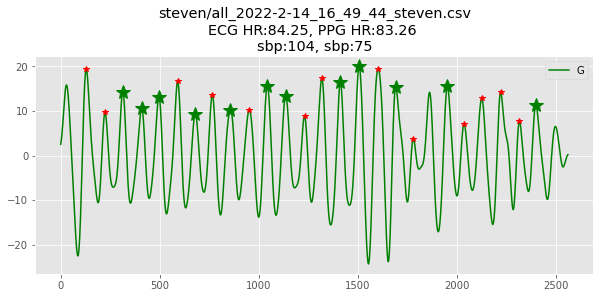

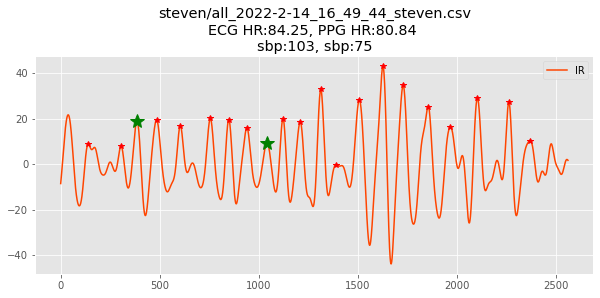

In [8]:

folder = 'BP'
# subjects = ["Shawn_all_2022-4-26_16_53_38.csv", "Steven_all_2022-4-26_16_54_51.csv"]
subjects = ["steven/all_2022-2-14_16_49_44_steven.csv"]

'''overall parameters '''

sr = 128
window = sr*20

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)

LEDs = ['G', 'IR']

for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data", 'stark', folder, file_name)
    data = file_read.stark_reader(full_file_path)
    # ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    # ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    
    start_sec = 2
    step_sec = 20
    end_sec = 20

    for start_sec in range(start_sec, end_sec, step_sec):
        
        s1 = start_sec*sr
        s2 = s1+window 

        '''Read ECG '''
        ecg_sample = np.array(data['ecg'][s1:s2])
        filt_ecg = np.array(ecg.final_filter(ecg_sample, sr, 4))
        filt_ecg = sp.z_score(filt_ecg)
        ecg_proc = ecg.ecg_preprocess(ecg_sample, sr)
        ecg_proc = np.array(ecg_proc)
        ecg_hr_list, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)
        ecg_hr = np.round(np.mean(ecg_hr_list),2)
        
        rr_sample = np.diff(rpeak)  # unit in sample points 

        ''' Read PPG '''
        
        
        
        for LED in LEDs:
            
            ppg = data[LED][s1:s2]
            filt_ppg = signal.filtfilt(b, a, ppg)

            ''' ppg preprocessing  '''
            pks_loc, trs_loc= sp.find_peak_valley(sr, filt_ppg)
            pulse_loc = sp.pulse_seg(pks_loc, trs_loc)
            num_pulse = len(pulse_loc)
            
            mean_rr = int(np.mean(rr_sample) + 0.5) # unit in sample points
            
            # Pulse only satisfied 
            qlist = interval_compare(pulse_loc, mean_rr)
            
            # pulse both satisfied similarity and pulse width tolerance
            hq_idx, xcorr = quality_inspection(filt_ppg, sr, pulse_loc, template_length=mean_rr, xcorr_thr=0.8)
            
            Dt_list = []
            ppg_hr_list = []
            for n in range(num_pulse):
                nni = (pulse_loc[n][2] - pulse_loc[n][0])
                _hr = np.round((60*(sr/nni)), 2)
                # diff = nni-rr
                if hq_idx[n]==1:
                    Dt = (pulse_loc[n][2] - pulse_loc[n][1])/sr
                    
                    Dt_list.append(Dt)
                    ppg_hr_list.append(_hr)
                    # print('ppg hr:{}, Dt:{}, ecg hr:{}'.format(_hr, Dt, ecg_hr))

                if Dt_list ==[]:    
                    sbp = None
                    dbp = None
                    ppg_hr = None
                    mean_Dt = None
                else:
                    mean_Dt = np.round(np.mean(Dt_list), 2)
                    sbp, dbp = BP_calc(mean_Dt, ecg_hr)
                    ppg_hr = np.round(np.mean(ppg_hr_list),2)
                      
            ''' Plot figure '''
            plt.figure(figsize=(10,4))
            plot_title = subject + "\n"
            plot_title = plot_title + "ECG HR:{}, PPG HR:{} \n".format(ecg_hr, ppg_hr)
            plot_title = plot_title + "sbp:{}, sbp:{}".format(sbp, dbp)
            plt.title(plot_title)
            
            if LED == 'G':
                plt.plot(filt_ppg, label='G', color='g')
            else:
                plt.plot(filt_ppg, label='IR', color='orangered')
                
                
            plt.legend()
            for j in range(num_pulse):
                pk_loc= pulse_loc[j][1]
                if qlist[j] ==1:
                    plt.plot(pk_loc, filt_ppg[pk_loc], color='green' , marker='*', markersize=14)
                else:
                    plt.plot(pk_loc, filt_ppg[pk_loc], color='red' , marker='*')

        
        '''Plot ecg '''
        # modify_rpeak = local_max(filt_ecg, rpeak, w=8)
        
        # plt.figure(figsize=(12,4))
        # plt.title(subject)
        # # plt.plot(filt_ecg, label='ECG')
        # # plt.plot(rpeak, filt_ecg[rpeak], '*')
        # for rp in rpeak:
        #     plt.axvline(rp, color='brown', ls='-.')
        
        
